# Introduction

This kernel contains the exploratory analysis and modeling to fraud detection problem from the [IEEE-CIS Fraud Detection Competition](https://www.kaggle.com/competitions/ieee-fraud-detection/overview).

Fraud detection systems help to save consumers millions of dollars per year and the performance of the detection models is extremely important to avoid consumer annoyance.

### Table of Contents

* [Required Libraries and Data](#libs)
* [Data Exploration](#exploration)
    * [Target Distribution](#target)
    * [Transaction Amount](#amount)

# <a id="libs"></a>Required Libraries and Data

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore" # ignore warnings on multiprocessing units

from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter("ignore") # ignore warnings

import random
seed = 42 # default seed
random.seed(seed)
np.random.seed(seed)

pd.set_option("display.max_columns", 9999)
pd.set_option("display.max_rows", 9999)

sns.set_style("darkgrid")

The train and test datasets are separeted between identity and transaction. The first identifies the customer and contains informations about network connection and digital signature. The transactions data contains informations about the transaction, such as the product, card, transaction amount and others.

In [2]:
"""
    Load data and optimize memory usage
"""
def load_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join("..", "input", "ieee-fraud-detection", filename))
    numerics = df.select_dtypes(include=[int, float]).columns.to_list()
    ints = (np.iinfo(np.int8), np.iinfo(np.int16), np.iinfo(np.int32), np.iinfo(np.int64))
    floats = (np.finfo(np.float16), np.finfo(np.float32), np.finfo(np.float64), np.finfo(np.float128))

    for col in numerics:
        min_val = df[col].min()
        max_val = df[col].max()

        if "int" in df[col].dtype.name:
            for info in ints:
                if min_val >= info.min and max_val <= info.max:
                    df[col] = df[col].astype(info.dtype)
                    break
        else:
            for info in floats:
                if min_val >= info.min and max_val <= info.max:
                    df[col] = df[col].astype(info.dtype)
                    break

    return df

In [3]:
df_id = load_data("train_identity.csv")
df_trans = load_data("train_transaction.csv")

In [6]:
def summarize_features(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    table_data = []
    for feature in features:
        data = df[feature]
        dtype = data.dtype.name
        missing = np.round(((data.isnull().sum() / len(data)) * 100), 2).astype(str) + "%"
        uniques = data.nunique()
        value_counts = data.value_counts(normalize=True, sort=True, ascending=False)
        first = value_counts.index.values[0] if len(value_counts) > 0 else np.nan
        second = value_counts.index.values[1] if len(value_counts) > 1 else np.nan
        third = value_counts.index.values[2] if len(value_counts) > 2 else np.nan
        table_data.append((feature, dtype, missing, uniques, first, second, third))

    return pd.DataFrame(data=table_data, columns=["Name", "dtype", "Missing", "Uniques", "#1 Value", "#2 Value", "#3 Value"])

In [7]:
summarize_features(df_trans, df_trans.columns.to_list()).head(25)

,Name,dtype,Missing,Uniques,#1 Value,#2 Value,#3 Value
0,TransactionID,int32,0.0%,590540,2987000,3380885,3380689
1,isFraud,int8,0.0%,2,0,1,NaN
2,TransactionDT,int32,0.0%,573349,9474817,11576951,4397066
3,TransactionAmt,float16,0.0%,8195,59.0,117.0,107.9375
4,ProductCD,object,0.0%,5,W,C,R
5,card1,int16,0.0%,13553,7919,9500,15885
6,card2,float16,1.51%,500,321.0,111.0,555.0
7,card3,float16,0.27%,114,150.0,185.0,106.0
8,card4,object,0.27%,4,visa,mastercard,american express
9,card5,float16,0.72%,119,226.0,224.0,166.0


In [8]:
summarize_features(df_id, df_id.columns.to_list()).head(25)

,Name,dtype,Missing,Uniques,#1 Value,#2 Value,#3 Value
0,TransactionID,int32,0.0%,144233,2987004,3334440,3334371
1,id_01,float16,0.0%,77,-5.0,0.0,-10.0
2,id_02,float32,2.33%,115655,1102.0,696.0,1141.0
3,id_03,float16,54.02%,24,0.0,1.0,3.0
4,id_04,float16,54.02%,15,0.0,-5.0,-6.0
5,id_05,float16,5.11%,93,0.0,1.0,2.0
6,id_06,float16,5.11%,101,0.0,-1.0,-5.0
7,id_07,float16,96.43%,84,0.0,16.0,14.0
8,id_08,float16,96.43%,94,-100.0,0.0,-34.0
9,id_09,float16,48.05%,46,0.0,1.0,3.0


# <a id="exploration"></a>Data Exploration

### <a id="target"></a>Target Distribution

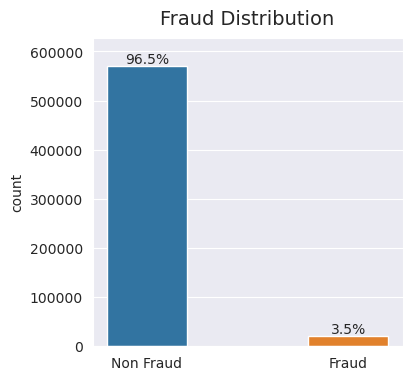

In [79]:
target_counts = df_trans["isFraud"].value_counts().reset_index(name="count").rename(columns=dict(index="isFraud"))
plt.figure(figsize=(4, 4))
plt.title("Fraud Distribution", fontsize=14, pad=10)
ax = sns.barplot(data=target_counts, x="isFraud", y="count", width=0.4)
for i, p in enumerate(ax.patches):
    ax.annotate(
        round((target_counts["count"].iloc[i] / target_counts["count"].sum()) * 100, 2).astype(str) + "%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 5),
        textcoords = 'offset points'
    )
plt.margins(0.05, 0.1)
plt.xticks([0, 1], ["Non Fraud", "Fraud"])
plt.xlabel("")
plt.ylabel("count")

plt.show()

### <a id="amount"></a>Transaction Amount

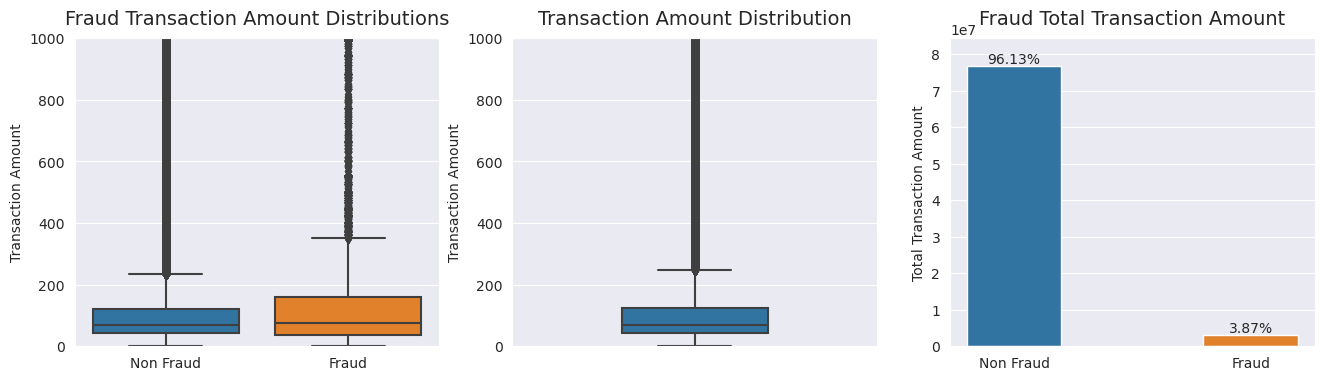

In [97]:
trans_amt = df_trans.groupby("isFraud")["TransactionAmt"].sum().reset_index(name="TransactionAmt").rename(columns=dict(index="isFraud"))
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title("Fraud Transaction Amount Distributions", fontsize=14, pad=10)
ax = sns.boxplot(data=df_trans, x="isFraud", y="TransactionAmt")
plt.ylim((0, 1000))
plt.xticks([0, 1], ["Non Fraud", "Fraud"])
plt.xlabel("")
plt.ylabel("Transaction Amount")

plt.subplot(132)
plt.title("Transaction Amount Distribution", fontsize=14, pad=10)
ax = sns.boxplot(data=df_trans, y="TransactionAmt", width=0.4)
plt.ylim((0, 1000))
plt.ylabel("Transaction Amount")

plt.subplot(133)
plt.title("Fraud Total Transaction Amount", fontsize=14, pad=10)
ax = sns.barplot(data=trans_amt, x="isFraud", y="TransactionAmt", width=0.4)
for i, p in enumerate(ax.patches):
    ax.annotate(
        round((trans_amt["TransactionAmt"].iloc[i] / trans_amt["TransactionAmt"].sum()) * 100, 2).astype(str) + "%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 5),
        textcoords = 'offset points'
    )
plt.margins(0.05, 0.1)
plt.xticks([0, 1], ["Non Fraud", "Fraud"])
plt.xlabel("")
plt.ylabel("Total Transaction Amount")

plt.show()